In [8]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.998e10 # cms-1
# G = c = 1

In [10]:
# Working in manual cgs units here. 
def _dPdr(r, P, M, e):
    factor = -G/(c**2) 
    term1 = (e+P) 
    term2 = (M+4*np.pi*(r**3)*P/(c**2))
    term3 = r * (r-2*G*M/(c**2))
    return factor * (term1 * term2)/term3
    
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))


def coupledTOV(r, VEC, f_e_smooth):
    P, M = VEC
    e = f_e_smooth(P)   
    dPdr = _dPdr(r, P, M, e)
    dMdr = _dMdr(r, e)
    return [dPdr, dMdr]

In [11]:
df = pd.read_csv("sly.csv")
n_den = 2.3e14
e_den = df.energy_densityc2
e_den_normed = e_den#/n_den
p = df.pressurec2

e_den_normed = e_den_normed*(c**2)
pressure = p*(c**2)
pressure = pressure.to_numpy()
e_den_normed = e_den_normed.to_numpy()
f_e_smooth = interp1d(pressure, e_den_normed, fill_value="extrapolate")

In [12]:
# Initial Conditions
km2cm = 1e5
# R = 20 * km2cm
R = 982982
r_i = 1e-8
r_f = R
p_c = pressure[-4]
e_c = f_e_smooth(p_c)
m0 = e_c * 4/3 * np.pi * r_i**3
init_VEC = [p_c, m0]
msun = 2e33
p_min = min(pressure)

In [13]:
func = f_e_smooth

r = ode(lambda r, VEC: coupledTOV(r, VEC, func)).set_integrator('LSODA')
r.set_initial_value(init_VEC, r_i)

results = []
r_list = []

i = 0
r_max = 20 * km2cm
max_iter = 1000000

dr_init = r_max/max_iter
dr_compute = 100000
print("r_step", dr_init)

pbar = tqdm(total=max_iter)

while r.successful() and (r.y[0] > p_min):
    i+=1
    
    dr = min(dr_init, dr_compute)
    
    integral = r.integrate(r.t+dr)

    results.append(integral)
    r_list.append(r.t+dr_init)
    
#     dr_compute = r * dP /P 
    
    pbar.update(1)
    if i > max_iter:
        print("[STATUS] max_iter reached")
        break
pbar.close()

  2%|▏         | 16962/1000000 [00:00<00:11, 82217.19it/s]

r_step 2.0


 48%|████▊     | 479326/1000000 [00:05<00:05, 89616.81it/s]


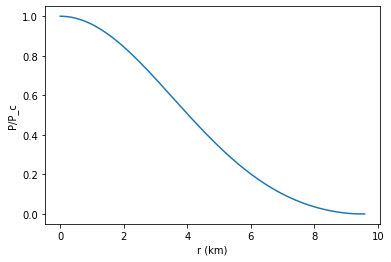

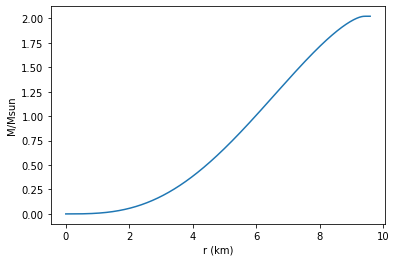

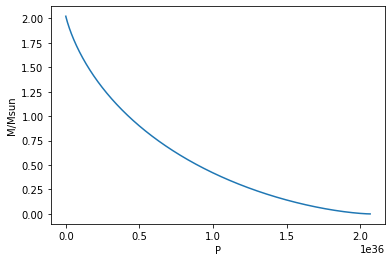

In [14]:
results = np.array(results, dtype = float)
p, m = results.T
r_arr = np.array(r_list)/km2cm
m = m/msun

plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r (km)")
plt.ylabel("P/P_c")

plt.figure()
plt.plot(r_arr, m)
plt.xlabel("r (km)")
plt.ylabel("M/Msun")

plt.figure()
plt.plot(p, m)
plt.xlabel("P")
plt.ylabel("M/Msun")
plt.show()